In [1]:
import gzip
try: import simplejson as json
except ImportError: import json

import codecs
import matplotlib.pyplot as plt
import numpy as np

In [4]:
def parse(filename):
  #f = gzip.open(filename, 'r')
  f = codecs.open(filename,encoding='latin-1')
  entry = {}
  for l in f:
    l = l.strip()
    colonPos = l.find(':')
    if colonPos == -1:
      yield entry
      entry = {}
      continue
    eName = l[:colonPos]
    rest = l[colonPos+2:]
    entry[eName] = rest
  yield entry

In [5]:
ratebeer_data = []
for e in parse("ratebeer.txt"):
    ratebeer_data.append(e)

In [10]:
print("Number of Ratebeer beer reviews: {}".format(len(ratebeer_data)))

Number of Ratebeer beer reviews: 2924164


In [14]:
ratebeer_data[10000]

{'beer/ABV': '8',
 'beer/beerId': '52',
 'beer/brewerId': '12',
 'beer/name': 'Chimay Triple / Blanche &#40;White&#41; / Cinq Cents',
 'beer/style': 'Abbey Tripel',
 'review/appearance': '4/5',
 'review/aroma': '8/10',
 'review/overall': '18/20',
 'review/palate': '3/5',
 'review/profileName': 'Naka',
 'review/taste': '8/10',
 'review/text': 'Pours a hazy blond apple cider color.  Small fizzy white head.  Nose of bananas, clove, yeast, and just a whispering of alcohol.  A great bitterness that is very light.  Some yeasty bread flavors with a nice fruity layer.  Leaves a pretty dry finish.  I know everyone loves the blue, but the white is definitely my favorite.',
 'review/time': '1201478400'}

In [16]:
#construct the reduced file with only productid, userid, rating
keep_property_arr =["beer/beerId", "review/profileName", "review/overall","review/time"]

In [47]:
ratebeer_reduced =[]
ratebeer_missingproperties = []
i=0
for review in ratebeer_data:
    user_jsobobj = dict()
    flag=0
    for prop in keep_property_arr:
        if prop not in review:
            ratebeer_missingproperties.append(review)
            flag=1
            break
    if flag==0:
        for property in keep_property_arr:
            if property =="review/overall":
                user_jsobobj["review/score"] = float(review[property].split("/")[0])/4.0
            elif property == "review/profileName":
                user_jsobobj["review/userId"] = review[property]
            elif property == "beer/beerId":
                user_jsobobj["product/productId"] = review [property]
            else:
                user_jsobobj[property] = review[property]
        ratebeer_reduced.append(user_jsobobj)

In [48]:
ratebeer_reduced[0]

{'product/productId': '63836',
 'review/score': 3.25,
 'review/time': '1157587200',
 'review/userId': 'hopdog'}

In [49]:
print("Number of 'clean' reviews: {}".format(len(ratebeer_reduced)))
print("Number of reviews with incomplete information: {}".format(len(ratebeer_missingproperties)))

Number of 'clean' reviews: 2924163
Number of reviews with incomplete information: 1


In [45]:
# Dump all clean and unclean contents to separate files. These files are used for all further processing

In [50]:
with open("ratebeer_incompletedata.json",'w') as outfile:
    for line in ratebeer_missingproperties:
        json.dump(line,outfile)
        outfile.write("\n")
print("File {} written".format("ratebeer_incompletedata.json"))
outfile.close()

File ratebeer_incompletedata.json written


In [51]:
with open("ratebeer_reduced_time_data.json",'w') as outfile:
    json.dump(ratebeer_reduced,outfile)
print("File {} written".format("ratebeer_reduced_time_data.json"))
outfile.close()

File ratebeer_reduced_time_data.json written


## Exploratory analysis

In [52]:
user_set = set()
product_set = set()

In [53]:
scores =[]

In [54]:
for review in ratebeer_reduced:
    if review["product/productId"] not in product_set:
        product_set.add(review["product/productId"])
    if review["review/userId"] not in user_set:
        user_set.add(review["review/userId"])
    scores.append(review["review/score"])

In [55]:
print("Number of products: {}".format(len(product_set)))
print("Number of users: {}".format(len(user_set)))

Number of products: 110369
Number of users: 29265


In [56]:
distinct_scores = dict()
for score in scores:
    if score not in distinct_scores:
        distinct_scores[score]=1
    else:
        distinct_scores[score]+=1

In [57]:
distinct_scores.keys()

dict_keys([3.5, 3.75, 2.0, 3.0, 4.0, 5.0, 1.0, 1.5, 1.75, 2.25, 2.5, 3.25, 0.25, 1.25, 4.75, 2.75, 4.25, 0.75, 4.5, 0.5])

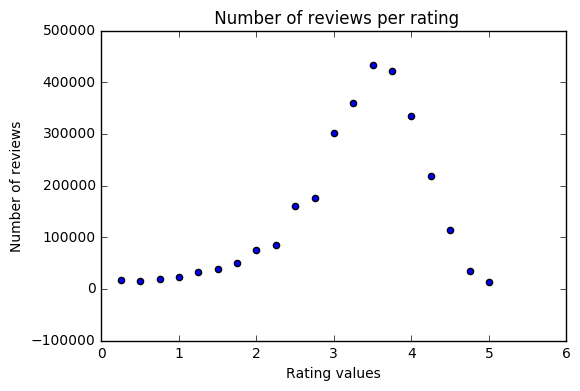

In [58]:
plt.scatter(list(distinct_scores.keys()),list(distinct_scores.values()))
plt.xlabel("Rating values")
plt.ylabel("Number of reviews")
plt.title(" Number of reviews per rating")
plt.show()

In [59]:
#figure out distribution of average rating of products / or ratings given by users
Iu = dict()
Ui = dict()

In [61]:
for review in ratebeer_reduced:
    if review["product/productId"] in Ui:
        Ui[review["product/productId"]].append(float(review["review/score"]))
    else:
        Ui[review["product/productId"]] = [float(review["review/score"])]
    if review["review/userId"] in Iu:
        Iu[review["review/userId"]].append(float(review["review/score"]))
    else:
        Iu[review["review/userId"]] = [float(review["review/score"])]

In [62]:
Iu_len = dict()
len_user = []
for key in Iu:
    if len(Iu[key]) not in Iu_len:
        Iu_len[len(Iu[key])]=1
    else:
        Iu_len[len(Iu[key])]+=1
    len_user.append(len(Iu[key]))

In [63]:
len_user.sort()

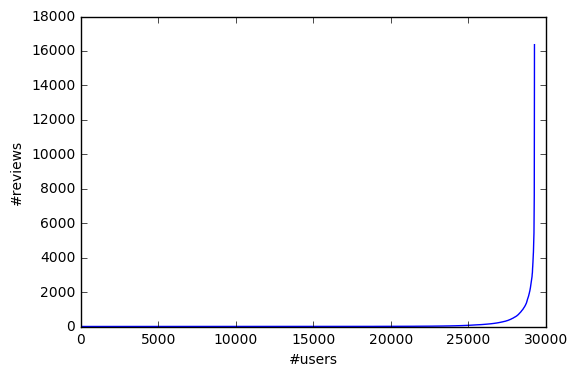

In [64]:
plt.plot(len_user)
plt.xlabel("#users")
plt.ylabel("#reviews")
plt.show()

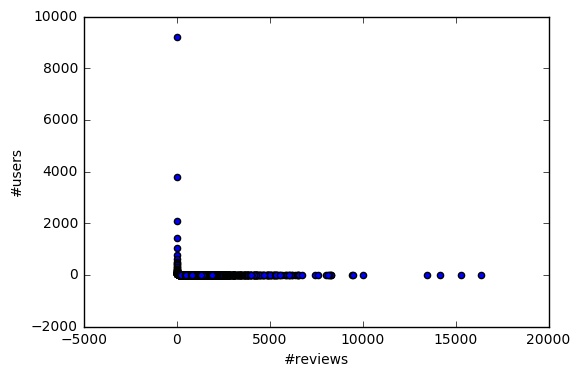

In [65]:
plt.scatter(list(Iu_len.keys()),list(Iu_len.values()))
plt.ylabel("#users")
plt.xlabel("#reviews")
plt.show()

In [69]:
review_cutoff = 50

In [70]:
count = 0
for key in Iu_len:
    if key>review_cutoff:
        count+= Iu_len[key]
        

In [71]:
print("Number of users who have written more than {} reviews is {}".format(review_cutoff,count))

Number of users who have written more than 50 reviews is 4760


In [72]:
avg_user_rating = dict()
for key in Iu:
    if np.mean(Iu[key]) not in avg_user_rating:
        avg_user_rating[np.mean(Iu[key])]=1
    else:
        avg_user_rating[np.mean(Iu[key])]+=1

In [73]:
x = sorted(list(avg_user_rating.keys()),reverse=True)

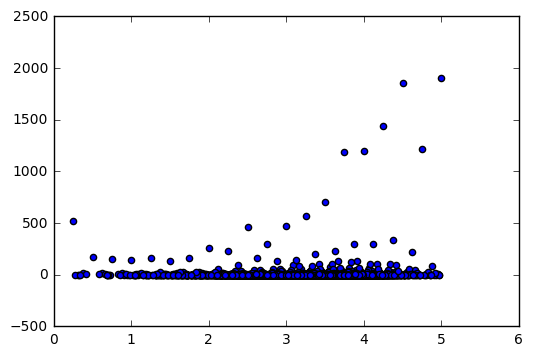

In [74]:
plt.scatter(list(avg_user_rating.keys()), list(avg_user_rating.values()))
plt.show()

In [3]:
from sklearn.model_selection import train_test_split
try: import simplejson as json
except ImportError: import json

In [4]:
with open("ratebeer_reduced_time_data.json","r") as infile:
    ratebeer_data = json.load(infile)

In [5]:
print("Number of reviews: {}".format(len(ratebeer_data)))

Number of reviews: 2924163


In [7]:
train, test = train_test_split(ratebeer_data,test_size=0.2, random_state=42)

In [9]:
print(len(train),len(test))

2339330 584833


In [10]:
train, val = train_test_split(train,test_size=0.25, random_state=42)

In [11]:
print(len(train),len(val),len(test))

1754497 584833 584833


In [14]:
with open("ratebeer_train.json",'w') as outfile:
    json.dump(train,outfile)
print("File {} written".format("ratebeer_train.json"))
outfile.close()

File ratebeer_train.json written


In [16]:
with open("ratebeer_test.json",'w') as outfile:
    json.dump(test,outfile)
print("File {} written".format("ratebeer_test.json"))
outfile.close()

File ratebeer_test.json written


In [17]:
with open("ratebeer_validation.json",'w') as outfile:
    json.dump(val,outfile)
print("File {} written".format("ratebeer_validation.json"))
outfile.close()

File ratebeer_validation.json written
